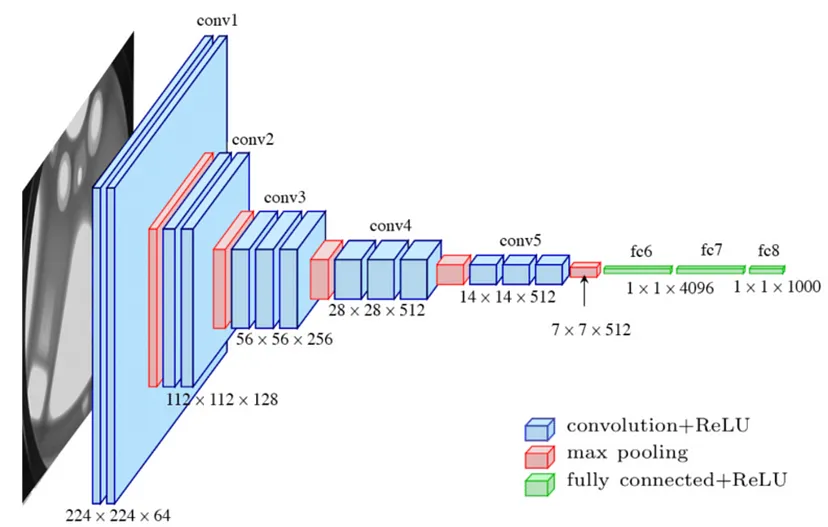

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
def data_loader(data_dir, batch_size, random_seed = 42, valid_size = 0.1, shuffle = True, test = False):
  normalize = transforms.Normalize(
      mean = [0.4914, 0.4822, 0.4465], # x - mean / std
      std = [0.2023, 0.1994, 0.2010]
  )

  # define transforms
  transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      normalize
  ])

  if test:
    dataset = datasets.CIFAR100(
        root = data_dir,
        train = False,
        download = True,
        transform = transform
    )

    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = shuffle
    )

    return data_loader

# load the dataset
  train_dataset = datasets.CIFAR100(
    root = data_dir,
    train = True,
    download = True,
    transform = transform
  )

  valid_dataset = datasets.CIFAR100(
    root = data_dir,
    train = True,
    download = True,
    transform = transform
  )

  num_train = len(train_dataset)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(valid_size * num_train))

  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = batch_size,
        sampler = train_sampler
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size = batch_size,
        sampler = valid_sampler
    )

    return (train_loader, valid_loader)

In [4]:
train_loader, valid_loader = data_loader(data_dir="./data", batch_size=64)
test_loader = data_loader(data_dir="./data", batch_size=64, test=True)


100%|██████████| 169M/169M [00:02<00:00, 81.8MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [5]:
class VGG16(nn.Module):
  def __init__(self, num_classes = 10):
    super(VGG16, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer5 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )
    self.layer6 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )
    self.layer7 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer8 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )
    self.layer9 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )
    self.layer10 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer11 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )
    self.layer12 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )
    self.layer13 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(7*7*512, 4096),
        nn.ReLU()
    )
    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU()
    )
    self.fc2 = nn.Sequential(
        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.layer6(out)
    out = self.layer7(out)
    out = self.layer8(out)
    out = self.layer9(out)
    out = self.layer10(out)
    out = self.layer11(out)
    out = self.layer12(out)
    out = self.layer13(out)

    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    out = self.fc1(out)
    out = self.fc2(out)

    return out


In [6]:
#Hyper Parameters
num_classes = 100
num_epochs = 20
batch_size = 16
learning_rate = 0.001

In [7]:
model = VGG16(num_classes).to(device)

In [8]:
model.parameters

<bound method Module.parameters of VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer6): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer7): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer8): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer9): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer10): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer11): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer12): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer13): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=25088, out_features=4096, bias=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=4096, out_features=100, bias=True)
  )
)>

In [9]:
# loss and optimzer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [10]:
total_step = len(train_loader)
total_step

704

In [ ]:
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    #forward Pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    #backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
        epoch+1, num_epochs, i+1, total_step, loss.item()
        ))

  # Validation

  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      del images, labels, outputs

  print("Accuracy of model on Test data: {:.2f}%".format(100 * correct / total))
